In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import os
import sys
sys.path.append('..')

import glob
import pickle
from edfreader import read_edf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Microsaccades

Détection et suppression des microsaccades pendant la fixation

In [2]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)
    #print(a)

exp = []
for x in range(len(liste)) :
    if liste[x][0]=='enregistrement' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [3]:
timeStr = {}
timeStr['AM'] = '2017-10-23_100057'
timeStr['BMC'] = '2017-09-26_095637'
timeStr['CS'] = '2017-10-03_134421'
timeStr['DC']= '2017-09-27_161040'
timeStr['FM'] = '2017-10-03_143803'
timeStr['IP'] = '2017-09-28_115250'
timeStr['LB'] = '2017-09-20_151043'
timeStr['OP'] = '2017-10-26_121823'
timeStr['RS'] = '2017-11-08_094717'
timeStr['SR'] = '2017-11-16_153313'
timeStr['TN'] = '2017-11-08_150410'
timeStr['YK'] = '2017-11-17_172706'

In [4]:
def suppression_saccades(gradient_deg, trackertime, saccades, trackertime_0):
    
    gradient_deg_NAN = gradient_deg
    
    for s in range(len(saccades)) :
        if saccades[s][1]-trackertime_0+15 <= (len(trackertime)) :
            for x_data in np.arange((saccades[s][0]-trackertime_0-5), (saccades[s][1]-trackertime_0+15)) :
                gradient_deg_NAN[x_data] = np.nan
        else :
            for x_data in np.arange((saccades[s][0]-trackertime_0-5), (len(trackertime))) :
                gradient_deg_NAN[x_data] = np.nan
    return gradient_deg_NAN

In [5]:
def Microsaccade (gradx, grady, VFAC=5, mindur=5, maxdur=100, minsep=30, trackertime_0=0):
    '''
    mindur et maxdur en ms
    '''    
    msdx = np.sqrt((np.nanmedian(gradx**2))-((np.nanmedian(gradx))**2))
    msdy = np.sqrt((np.nanmedian(grady**2))-((np.nanmedian(grady))**2))
    
    radiusx = VFAC*msdx
    radiusy = VFAC*msdy

    test = (gradx/radiusx)**2 + (grady/radiusy)**2
    index = [x for x in range(len(test)) if test[x] > 1]
    
    dur = 0
    debut_sac = 0
    
    sac = []
    for i in range(len(index)-1) :
        if index[i+1]-index[i]==1 :
            dur = dur + 1;
        else :
            if dur >= mindur and dur < maxdur :
                fin_sac = i
                sac.append([index[debut_sac]+trackertime_0, index[fin_sac]+trackertime_0])
            debut_sac = i+1
            dur = 1
        
    if len(sac) > 1 :
        s=0
        while s < len(sac)-1 :
            sep = sac[s+1][0]-sac[s][1] # temporal separation between onset of saccade j+1 and offset of saccade j
            if sep < minsep :
                sac[s][1] = sac[s+1][1] #the two saccades are fused into one
                del(sac[s+1])
                s=s-1
            s=s+1
        
    s=0
    while s < len(sac) :
        dur = sac[s][1]-sac[s][0] # duration of jth saccade
        if dur >= maxdur :
            del(sac[s])
            s=s-1
        s=s+1  
        
        
    return sac

In [6]:
def fig_velocity(ax, sujet, block, trial, fusion=False) :

    t_label=10
    
    trial_data = trial + 200*block
    
    resultats = os.path.join('..','data', 'enregistrement_' + sujet + '_' + timeStr[sujet] + '.asc')
    data = read_edf(resultats, 'TRIALID')
    
    data_x = data[trial_data]['x']
    data_y = data[trial_data]['y']
    
    trackertime_0 = data[trial_data]['trackertime'][0]
    TargetOn = data[trial_data]['events']['msg'][15][0]
    trackertime = data[trial_data]['trackertime']
    
    start = TargetOn
    
    TargetOn_s = TargetOn - start
    StimulusOn_s = data[trial_data]['events']['msg'][10][0] - start
    StimulusOf_s = data[trial_data]['events']['msg'][14][0] - start
    
    TargetOff_s = data[trial_data]['events']['msg'][16][0] - start
    trackertime_s = trackertime - start
    
    saccades = data[trial_data]['events']['Esac']

    gradient_x = np.gradient(data_x) # gradient en px/ms
    gradx = gradient_x * 1/exp[0]['px_per_deg'] * 1000 # gradient en deg/sec    
    
    gradient_y = np.gradient(data_y)
    grady = gradient_y * 1/exp[0]['px_per_deg'] * 1000
    
    if fusion==False :
        grad = suppression_saccades(gradx, trackertime, saccades, trackertime_0)
        sac = Microsaccade(gradx[:TargetOn-trackertime_0+100],grady[:TargetOn-trackertime_0+100])
        grad2 = gradx.copy()

    if fusion==True :
        misac = Microsaccade(gradx[:TargetOn-trackertime_0+100],grady[:TargetOn-trackertime_0+100], trackertime_0=trackertime_0)
        saccades.extend(misac)
        grad = suppression_saccades(gradx, trackertime, saccades, trackertime_0)
        
    
    ax.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
    ax.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
    ax.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)

    debut  = TargetOn - trackertime_0
    

    for s in range(len(saccades)) :
        ax.axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.15)
        
    ax.plot(trackertime_s, grad, color='k', alpha=0.4)
    
    if fusion==False :
        for s in range(len(sac)) :
            ax.axvspan(sac[s][0]-debut, sac[s][1]-debut, color='r', alpha=0.3)

            if sac[s][1]+15 <= (len(trackertime)) :
                for x_data in np.arange((sac[s][0]-5), (sac[s][1]+15)) :
                    grad2[x_data] = np.nan
            else :
                for x_data in np.arange((sac[s][0]-5), (len(trackertime))) :
                    grad2[x_data] = np.nan
                    
        ax.plot(trackertime_s, grad2, color='r', alpha=0.4)
    
    ax.axis([-750, 750, -39.5, 39.5])
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(labelsize=t_label/2)
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_tick_params(labelsize=t_label/2)
    ax.set_xlabel('Time (ms)', fontsize=t_label)

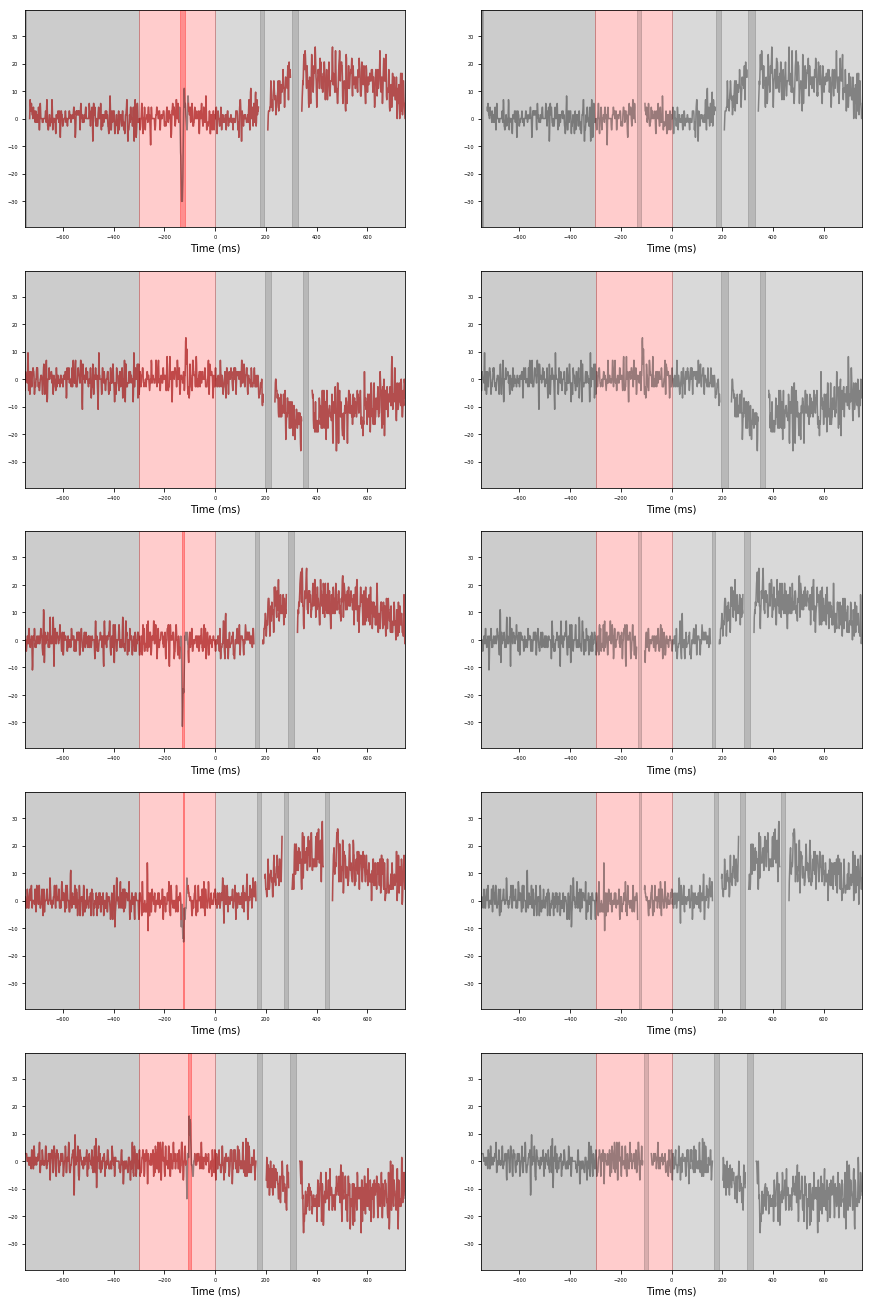

In [7]:
fig_width = 15
fig, ax = plt.subplots(5,2, figsize=(fig_width, 2.5*fig_width/1.6180))

for x in range(5) :
    fig_velocity(ax[x][0], sujet='CS', block=1, trial=x)
    fig_velocity(ax[x][1], sujet='CS', block=1, trial=x, fusion=True) 

## code matlab Anna Montagnini